# Finding SNP Regions

John Conery

This notebook has preliminary experiments with defining the "signal" (difference in cumulative sums of counts of SNPs) and using the SciPy peak finder function to look for places where a chromosome switches between SNPs from different sources.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.signal import find_peaks

### SNPs

Zac's data set is in two Pandas data frames:
* `bsp_COs_final_set` has locations of crossovers 
* `BSP_TIGER.marker_dataframe` has locations of SNPs

In [3]:
bsp_COs = pd.read_pickle('bsp_COs_final_set.pickle.gzip', compression='gzip')

In [4]:
bsp_SNPs = pd.read_pickle('BSP_TIGER.marker_dataframe.pickle.gzip', compression='gzip')

In [5]:
len(bsp_SNPs)

130290510

In [6]:
bsp_SNPs.head(5)

,Sample,chromosome,position,base_geno,hmm_state1,hmm_state2,reference,ref_reads,variant,var_reads,chrom_id
0,BSP-OR-202,1,855,unknown,N2,N2,G,0,C,0,BSP-OR-202-1
1,BSP-OR-202,1,1222,unknown,N2,N2,A,0,C,0,BSP-OR-202-1
2,BSP-OR-202,1,1933,unknown,N2,N2,C,0,G,0,BSP-OR-202-1
3,BSP-OR-202,1,3048,uN2,N2,N2,C,3,G,0,BSP-OR-202-1
4,BSP-OR-202,1,3659,N2,N2,N2,C,7,T,2,BSP-OR-202-1


### Example

Zac uses chromosome IV from OR-001 in his examples (see plot in `xo.ipynb`).

In [7]:
chr = bsp_SNPs[bsp_SNPs.chrom_id == 'BSP-OR-001-4']

In [8]:
len(chr)

25922

In [9]:
chr.head()

,Sample,chromosome,position,base_geno,hmm_state1,hmm_state2,reference,ref_reads,variant,var_reads,chrom_id
90348,BSP-OR-001,4,195,unknown,CB4856,CB4856,G,0,T,0,BSP-OR-001-4
90349,BSP-OR-001,4,57787,unknown,CB4856,CB4856,C,23,T,20,BSP-OR-001-4
90350,BSP-OR-001,4,68361,het,CB4856,CB4856,A,5,G,5,BSP-OR-001-4
90351,BSP-OR-001,4,69253,N2,CB4856,CB4856,A,9,G,7,BSP-OR-001-4
90352,BSP-OR-001,4,70396,N2,CB4856,CB4856,A,10,T,3,BSP-OR-001-4


In [10]:
chr.tail()

,Sample,chromosome,position,base_geno,hmm_state1,hmm_state2,reference,ref_reads,variant,var_reads,chrom_id
116265,BSP-OR-001,4,17489202,N2,N2,N2,C,23,T,5,BSP-OR-001-4
116266,BSP-OR-001,4,17490765,unknown,N2,N2,C,0,T,0,BSP-OR-001-4
116267,BSP-OR-001,4,17491619,N2,N2,N2,T,11,A,2,BSP-OR-001-4
116268,BSP-OR-001,4,17491911,N2,N2,N2,C,23,T,0,BSP-OR-001-4
116269,BSP-OR-001,4,17491928,N2,N2,N2,A,25,G,0,BSP-OR-001-4


The `hmm_state1` column has the data we want: for each SNP, did it come from the N2 ancestor or the CB4856 ancestor?  The values are Python strings ("object" as far as Numpy is concerned):

In [11]:
chr.hmm_state1.to_numpy()

array(['CB4856', 'CB4856', 'CB4856', ..., 'N2', 'N2', 'N2'], dtype=object)

### Define the Signal

* Create a binary column that is 0 where `hmm_state1` is `N2` and 1 where it's `CB4856`.
* Create another column with the cumulative sum of the binary values
* Define another column for the cumulative sum of opposite values

The "signal" we want to work with is the difference of the two sums.

This expression creates a vector of Booleans:

In [12]:
chr.hmm_state1 == 'N2'

90348     False
90349     False
90350     False
90351     False
90352     False
          ...  
116265     True
116266     True
116267     True
116268     True
116269     True
Name: hmm_state1, Length: 25922, dtype: bool

The cumulative sum method does just what we want, treating False as 0 and True as 1:

In [13]:
(chr.hmm_state1 == 'N2').cumsum()

90348        0
90349        0
90350        0
90351        0
90352        0
          ... 
116265    4768
116266    4769
116267    4770
116268    4771
116269    4772
Name: hmm_state1, Length: 25922, dtype: int64

In [14]:
(chr.hmm_state1 == 'CB4856').cumsum()

90348         1
90349         2
90350         3
90351         4
90352         5
          ...  
116265    21150
116266    21150
116267    21150
116268    21150
116269    21150
Name: hmm_state1, Length: 25922, dtype: int64

In [15]:
#signal = ((chr.hmm_state1 == 'CB4856').cumsum() - (chr.hmm_state1 == 'N2').cumsum()).to_numpy()
signal = ((chr.hmm_state1 == 'N2').cumsum() - (chr.hmm_state1 == 'CB4856').cumsum()).to_numpy()

In [16]:
signal

array([    -1,     -2,     -3, ..., -16380, -16379, -16378])

### Visualizations

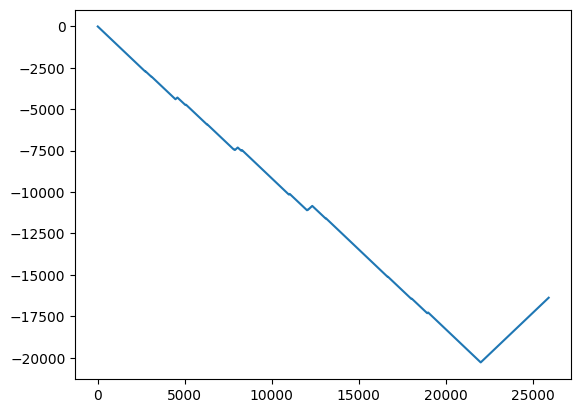

In [17]:
plt.plot(signal)

Zooming in on one of the peaks

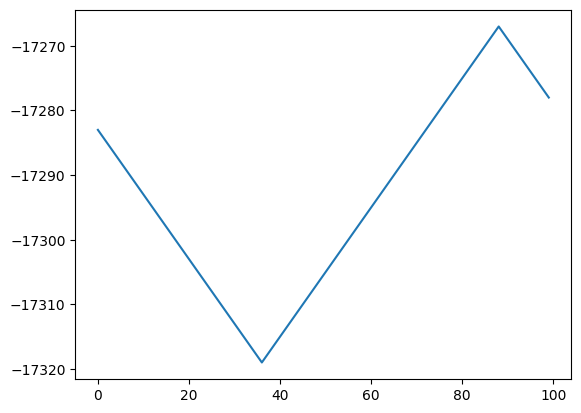

In [18]:
plt.plot(signal[18900:19000])

### Plot Peaks

In [19]:
def plot_peaks(wave, px):
    py = [ wave[x] for x in px ]
    plt.plot(wave)
    plt.plot(px, py, 'r.')

In [20]:
px, prop = find_peaks(signal)

In [21]:
px

array([ 2737,  3098,  4574,  5070,  6283,  7821,  8042,  8288, 11030,
       12069, 12326, 13116, 16680, 18051, 18988])

In [22]:
len(px)

15

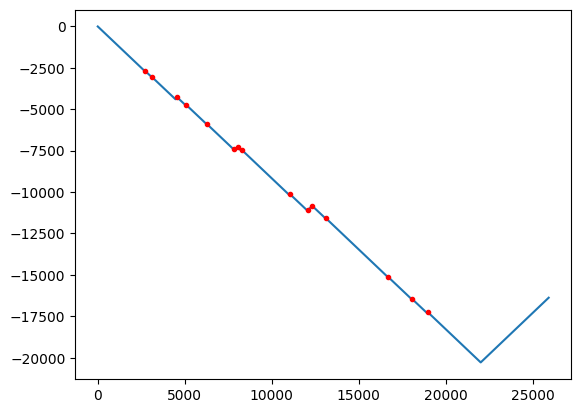

In [23]:
plot_peaks(signal, px)

The $x$-coordinates are row numbers in the frame.  If we print the rows around the peak we should see the state changes.

In [24]:
px[0]

np.int64(2737)

In [25]:
chr.iloc[2715:2740]

,Sample,chromosome,position,base_geno,hmm_state1,hmm_state2,reference,ref_reads,variant,var_reads,chrom_id
93063,BSP-OR-001,4,1996468,unknown,CB4856,CB4856,C,0,T,0,BSP-OR-001-4
93064,BSP-OR-001,4,1996645,CB4856,CB4856,CB4856,T,7,G,12,BSP-OR-001-4
93065,BSP-OR-001,4,1996955,het,CB4856,CB4856,G,3,A,6,BSP-OR-001-4
93066,BSP-OR-001,4,1996956,het,CB4856,unknown,G,3,A,6,BSP-OR-001-4
93067,BSP-OR-001,4,1997145,unknown,N2,unknown,T,0,A,0,BSP-OR-001-4
93068,BSP-OR-001,4,1997147,unknown,N2,unknown,T,0,C,0,BSP-OR-001-4
93069,BSP-OR-001,4,1997149,unknown,N2,unknown,T,0,A,0,BSP-OR-001-4
93070,BSP-OR-001,4,1997234,N2,N2,N2,G,6,A,0,BSP-OR-001-4
93071,BSP-OR-001,4,1997248,N2,N2,N2,T,8,A,0,BSP-OR-001-4
93072,BSP-OR-001,4,1997259,N2,N2,N2,T,8,C,0,BSP-OR-001-4


### Prominence

We can pass an option named "prominence" to `find_peaks` to tell it how much a peak needs to stand out from its surroundings.  An added bonus is the second object returned by the call tells us how big the peak is, _i.e._ how many SNPs are in the peak.

Setting `prominence` to 1 tells the function to return anything that stands out.

In [26]:
px, prop = find_peaks(signal, prominence=1)

In [27]:
px

array([ 2737,  3098,  4574,  5070,  6283,  7821,  8042,  8288, 11030,
       12069, 12326, 13116, 16680, 18051, 18988])

In [28]:
prop

{'prominences': array([ 19.,  13., 112.,  31.,  17.,  18., 159.,  45.,  48.,  14., 272.,
         20.,  17.,  24.,  52.]),
 'left_bases': array([ 2718,  3085,  4462,  5039,  6266,  7803,  7883,  8243, 10982,
        12026, 12026, 13096, 16663, 18027, 18936]),
 'right_bases': array([22010, 22010, 22010, 22010, 22010,  7883, 22010, 22010, 22010,
        12083, 22010, 22010, 22010, 22010, 22010])}

In [29]:
prop['prominences']

array([ 19.,  13., 112.,  31.,  17.,  18., 159.,  45.,  48.,  14., 272.,
        20.,  17.,  24.,  52.])

That output says the first peak (starting at location 2718) is 19 SNPs long, which agrees with the table shown above.

### Chromosome Location

The `signal` vector is indexed by SNP number.  It's easy enough to convert that back to a location on the chromosome using the `position` column in the frame.

The location returned by `find_peaks` is the location of the CB4856 SNP just before the sequence of N2.

In [30]:
chr.iloc[px[0]]     # expect to see a CB4856 SNP

Sample          BSP-OR-001
chromosome               4
position           1997566
base_geno          unknown
hmm_state1              N2
hmm_state2         unknown
reference                G
ref_reads                0
variant                  T
var_reads                0
chrom_id      BSP-OR-001-4
Name: 93085, dtype: object

In [31]:
chr.iloc[px[0]+1]    # expect an N2 SNP

Sample          BSP-OR-001
chromosome               4
position           1997578
base_geno              uN2
hmm_state1          CB4856
hmm_state2          CB4856
reference                G
ref_reads                1
variant                  C
var_reads                0
chrom_id      BSP-OR-001-4
Name: 93086, dtype: object

The last row in the sequence is in the `right_bases` property:

In [32]:
prop['right_bases'][0]

np.int64(22010)

In [33]:
chr.iloc[prop['right_bases'][0]]   # the last N2 SNP in this group

Sample          BSP-OR-001
chromosome               4
position          15669138
base_geno               N2
hmm_state1          CB4856
hmm_state2          CB4856
reference                T
ref_reads               18
variant                  A
var_reads                0
chrom_id      BSP-OR-001-4
Name: 112358, dtype: object

In [34]:
def chromosome_loc(snp):
    start = chr.iloc[px[snp]+1].position
    end = chr.iloc[prop['right_bases'][snp]].position
    return (int(start), int(end))

In [35]:
chromosome_loc(0)

(1997578, 15669138)

In [36]:
chromosome_loc(1)

(2157459, 15669138)

### Are the SNPs sorted by chromosome location?

In [37]:
schr = chr.sort_values(by="position")

In [38]:
ssignal = ((schr.hmm_state1 == 'CB4856').cumsum() - (schr.hmm_state1 == 'N2').cumsum()).to_numpy()

In [39]:
spx, sprop = find_peaks(ssignal, prominence=1)

In [40]:
spx

array([ 2718,  3085,  4462,  5039,  6266,  7803,  7883,  8243, 10982,
       12026, 12083, 13096, 16663, 18027, 18936, 22010])

In [41]:
px

array([ 2737,  3098,  4574,  5070,  6283,  7821,  8042,  8288, 11030,
       12069, 12326, 13116, 16680, 18051, 18988])

In [42]:
sprop

{'prominences': array([  19.,   13.,  112.,   31.,   17.,   18.,  159.,   45.,   48.,
         272.,   14.,   20.,   17.,   24.,   52., 3911.]),
 'left_bases': array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 12069,     0,     0,     0,     0,     0]),
 'right_bases': array([ 2737,  3098,  4574,  5070,  6283,  7821,  8042,  8288, 11030,
        12326, 12326, 13116, 16680, 18051, 18988, 25921])}

In [43]:
prop

{'prominences': array([ 19.,  13., 112.,  31.,  17.,  18., 159.,  45.,  48.,  14., 272.,
         20.,  17.,  24.,  52.]),
 'left_bases': array([ 2718,  3085,  4462,  5039,  6266,  7803,  7883,  8243, 10982,
        12026, 12026, 13096, 16663, 18027, 18936]),
 'right_bases': array([22010, 22010, 22010, 22010, 22010,  7883, 22010, 22010, 22010,
        12083, 22010, 22010, 22010, 22010, 22010])}

**Yes, the original frame is sorted by chromosome location.**

### Other Chromosomes

In [44]:
chromosome = bsp_SNPs[bsp_SNPs.chrom_id == 'BSP-OR-001-3']

In [45]:
signal = ((chromosome.hmm_state1 == 'CB4856').cumsum() - (chromosome.hmm_state1 == 'N2').cumsum()).to_numpy()
#signal = ((chromosome.hmm_state1 == 'N2').cumsum() - (chromosome.hmm_state1 == 'CB4856').cumsum()).to_numpy()

In [46]:
px, prop = find_peaks(signal, prominence=1)

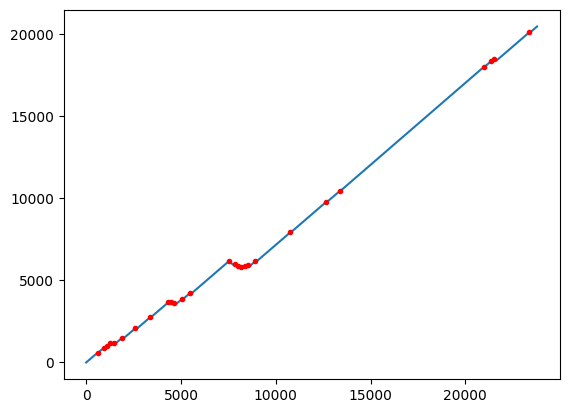

In [47]:
plot_peaks(signal, px)

In [48]:
px

array([  602,   938,  1079,  1269,  1495,  1909,  2573,  3358,  4321,
        4491,  4635,  5078,  5472,  7526,  7861,  8021,  8167,  8357,
        8538,  8922, 10763, 12661, 13389, 20960, 21357, 21531, 23369])

In [49]:
prop

{'prominences': array([ 17.,  15.,  23.,  90.,  49.,  57.,  56.,  24.,  58., 185.,  18.,
         30.,  52., 435.,  66.,  27.,  51.,  44.,  79.,  38.,  19.,  28.,
         16.,  19.,  16., 109.,  31.]),
 'left_bases': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4617,
           0,    0,    0, 7795, 7994, 8116, 8249, 8249, 8249,    0,    0,
           0,    0,    0,    0,    0]),
 'right_bases': array([  619,   953,  1102,  1359,  1544,  1966,  2629,  3382,  4379,
         4712,  4712,  5108,  5524,  8249,  8249,  8249,  8249,  8401,
         8617,  8960, 10782, 12689, 13405, 20979, 21373, 21640, 23400])}

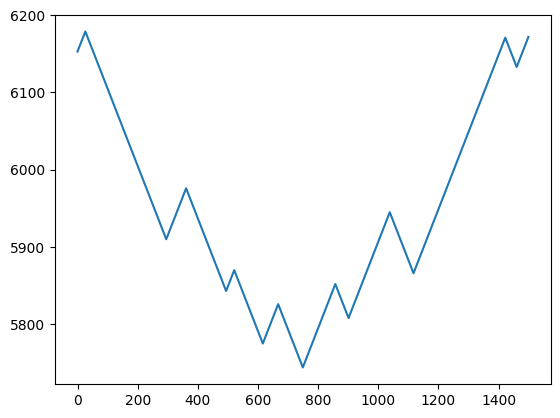

In [50]:
plot_peaks(signal[7500:9000],px[7500:9000])

In [51]:
def plot_segs(px, prop, x0, x1):
    for i in range(len(px)):
        if prop['left_bases'][i] == px[i] - prop['prominences'][i]:
            blk_start = prop['left_bases'][i] + 1
            blk_end = px[i]
        else:
            blk_start = px[i]+1
            blk_end = prop['right_bases'][i]
        if (blk_start > x1) or (blk_end < x0):
            continue
        plt.plot([blk_start, blk_end], [i,i], 'b-')

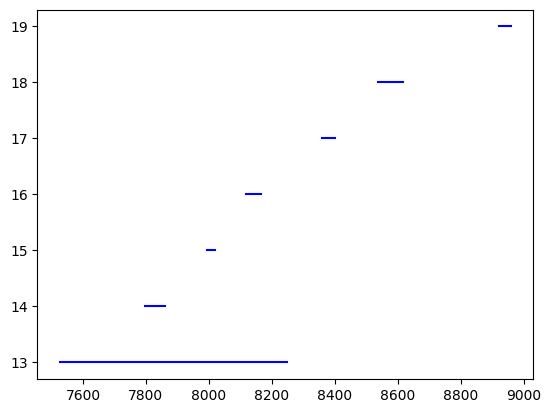

In [52]:
plot_segs(px,prop,7000,10000)

In [53]:
px[13], prop['prominences'][13], prop['left_bases'][13], prop['right_bases'][13]

(np.int64(7526), np.float64(435.0), np.int64(0), np.int64(8249))

In [54]:
px[14], prop['prominences'][14], prop['left_bases'][14], prop['right_bases'][14]

(np.int64(7861), np.float64(66.0), np.int64(7795), np.int64(8249))

In [55]:
for i in range(len(px)):
    if prop['left_bases'][i] == px[i] - prop['prominences'][i]:
        blk_start = prop['left_bases'][i] + 1
        blk_end = px[i]
    else:a
        blk_start = px[i]+1
        blk_end = prop['right_bases'][i]
    print(f'{blk_end-blk_start}: {blk_start}..{blk_end}')

IndentationError: unexpected indent (3329125036.py, line 6)

In [ ]:
chromosome.iloc[7308:7340]

,Sample,chromosome,position,base_geno,hmm_state1,hmm_state2,reference,ref_reads,variant,var_reads,chrom_id
30687,BSP-OR-202,2,1761963,het,CB4856,CB4856,A,5,G,5,BSP-OR-202-2
30688,BSP-OR-202,2,1761964,het,CB4856,CB4856,T,5,C,5,BSP-OR-202-2
30689,BSP-OR-202,2,1761968,het,CB4856,CB4856,T,5,C,5,BSP-OR-202-2
30690,BSP-OR-202,2,1761970,het,CB4856,CB4856,A,5,T,5,BSP-OR-202-2
30691,BSP-OR-202,2,1761987,CB4856,CB4856,CB4856,C,6,A,9,BSP-OR-202-2
30692,BSP-OR-202,2,1761989,CB4856,CB4856,CB4856,C,6,T,9,BSP-OR-202-2
30693,BSP-OR-202,2,1761993,CB4856,CB4856,CB4856,C,6,T,9,BSP-OR-202-2
30694,BSP-OR-202,2,1762022,CB4856,CB4856,CB4856,T,7,G,8,BSP-OR-202-2
30695,BSP-OR-202,2,1762076,N2,N2,N2,A,15,C,0,BSP-OR-202-2
30696,BSP-OR-202,2,1762082,N2,N2,N2,G,12,T,0,BSP-OR-202-2


In [ ]:
chromosome.iloc[18730:18809]

,Sample,chromosome,position,base_geno,hmm_state1,hmm_state2,reference,ref_reads,variant,var_reads,chrom_id
42109,BSP-OR-202,2,2904521,unknown,N2,N2,A,0,G,0,BSP-OR-202-2
42110,BSP-OR-202,2,2904525,unknown,N2,N2,T,0,A,0,BSP-OR-202-2
42111,BSP-OR-202,2,2904584,unknown,N2,N2,A,0,G,0,BSP-OR-202-2
42112,BSP-OR-202,2,2904670,unknown,N2,N2,A,0,G,0,BSP-OR-202-2
42113,BSP-OR-202,2,2904777,N2,N2,N2,A,8,G,0,BSP-OR-202-2
...,...,...,...,...,...,...,...,...,...,...,...
42183,BSP-OR-202,2,2921393,unknown,N2,N2,C,0,T,0,BSP-OR-202-2
42184,BSP-OR-202,2,2921690,uN2,N2,N2,T,2,C,0,BSP-OR-202-2
42185,BSP-OR-202,2,2921711,unknown,N2,N2,T,0,G,0,BSP-OR-202-2
42186,BSP-OR-202,2,2921836,unknown,N2,N2,G,0,A,0,BSP-OR-202-2
